In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys

import os
import datetime
import glob
import h5py

sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import astropy.coordinates as coord
import astropy.time as atime
import astropy.units as u

from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import scipy.io

In [3]:
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

<h1>03-Extract Data from KOA files</h1>
In this notebook, I extract the flux, wavelength, error data from many KOA data fits file. And store the important information in arrays that will used for fitting by jabble.

In [4]:
folders_name = ['KOA_123937/HIRES/extracted/**/*_flux.fits'] + ['KOA_123937_{}/HIRES/extracted/**/*_flux.fits'.format(x) for x in range(2,16)]
folders = [os.path.join('/scratch/mdd423/wobble_jax/data/gj436_HIRES',x) for x in folders_name]
files = glob.glob(folders[0], 
                   recursive = True)

In [5]:
hdu1 = fits.open('/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937/HIRES/extracted/binaryfits/ccd0/flux/HI.20040709.22379_0_12_flux.fits')
hdu1[0].header

SIMPLE  =                    T / Java FITS: Tue Nov 04 03:25:05 HST 2008        
BITPIX  =                  -32                                                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT FITS (Flexible Image Transport System) format defined in Astronomy and  
COMMENT Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.  
COMMENT Contact the NASA Science Office of Standards and Technology for the     
COMMENT FITS Definition document #100 and other FITS information.               
COMMENT The following keywords came from KTL via watch_ccd                      
UT      = '06:12:59.40'                                                         
DATE-OBS= '2004-07-09'                                                          
TEMPDET =        -119.66737366                                                  
TEMPSET =        -119.952163

In [6]:
observatory_name = 'Keck'
loc = coord.EarthLocation.of_site(observatory_name)
star_name = hdu1[0].header['TARGNAME']
star = coord.SkyCoord.from_name(star_name,parse=True)

In [7]:
hdu1 = fits.open('/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937/HIRES/extracted/binaryfits/ccd0/flux/HI.20040709.22379_0_12_flux.fits')
hdu1[0].header

SIMPLE  =                    T / Java FITS: Tue Nov 04 03:25:05 HST 2008        
BITPIX  =                  -32                                                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT FITS (Flexible Image Transport System) format defined in Astronomy and  
COMMENT Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.  
COMMENT Contact the NASA Science Office of Standards and Technology for the     
COMMENT FITS Definition document #100 and other FITS information.               
COMMENT The following keywords came from KTL via watch_ccd                      
UT      = '06:12:59.40'                                                         
DATE-OBS= '2004-07-09'                                                          
TEMPDET =        -119.66737366                                                  
TEMPSET =        -119.952163

In [8]:
def gaussian_function(xs,sigma):
    
    return jnp.sqrt(1/(2*np.pi*sigma**2)) * jnp.exp(-(xs)**2/(2*sigma**2))

def gaussian_filter(xs,ys,sigma):

    def _internal(x):
        return jnp.dot(ys,gaussian_function(x - xs,sigma))

    return jax.vmap(_internal,in_axes=(0,),out_axes=0)(xs)

In [9]:
sigma = np.log(5000) - np.log(4998.5)

In [10]:
import astropy.time as at

<h2>Loading in Data from Directories Here</h2>
Searches the directory for all flux files as downloaded from Keck Online Archive (KOA).

In [11]:
iteration = 0
airmasses = np.zeros(shape=(0))
bcs = np.zeros(shape=(0))
jds = np.zeros(shape=(0))
filenames = np.zeros(shape=(0))
objnames = np.zeros(shape=(0))
fluxes   = []
waves    = []
erres    = []
for folder in folders:
    
    files = glob.glob(folder, recursive = True)
    for file in files:
        
        try:
            hdu1 = fits.open(file)
        except:
            print(file)
            continue
            
        airmass = hdu1[0].header['AIRMASS']
        
        flux = jnp.array(hdu1[1].data['Flux'],dtype=np.float64)
        xs = jnp.log(jnp.array(hdu1[1].data['wave'],dtype=np.float64))
        ys = jnp.log(flux)
        yerr = jnp.array(hdu1[1].data['Error'],dtype=np.float64)/flux
        objname = hdu1[0].header['OBJFILE']

        try:
            jd = atime.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC']), format='isot', scale='utc')
        except:
            jd = atime.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT']), format='isot', scale='utc')
            
        fluxes.append(ys)
        waves.append(xs)
        erres.append(yerr)
        
        bc = star.radial_velocity_correction(obstime=jd, location=loc).to(u.m/u.s).value

        airmasses = np.concatenate((airmasses,[airmass]))
        bcs = np.concatenate((bcs,[bc]))
        jds = np.concatenate((jds,[jd.jd]))
        filenames = np.concatenate((filenames,[file]))
        objnames = np.concatenate((objnames,[objname]))
        
        # iteration += 1
        # if iteration > 2:
        #     break

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_06_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_08_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_04_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_07_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_12_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_HIRES/KOA_123937_12/HIRES/extracted/binaryfits/ccd1/flux/HI.201112

In [12]:
# np.save('/scratch/mdd423/wobble_jax/data/gj436_flux.nda',np.array(fluxes,dtype=object),   allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_wave.nda',np.array(waves,dtype=object),    allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_error.nda',np.array(erres,dtype=object),    allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_airmass.nda',np.array(airmasses,dtype=object),allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_bcs.nda',np.array(bcs,dtype=object),      allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_jds.nda',np.array(jds,dtype=object),      allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_filenames.nda',np.array(filenames,dtype=object),allow_pickle=True)
# np.save('/scratch/mdd423/wobble_jax/data/gj436_objnames.nda',np.array(objnames,dtype=object), allow_pickle=True)

Save lists of arrays from every file containing, log flux, log wavelength, log flux error, airmass, 

In [13]:
import astropy.time as at

In [14]:
times = [at.Time(x,format='jd').datetime for x in jds]

In [15]:
times = [str(x.year) + str(x.month) + str(x.day) for x in times]

In [16]:
len(np.unique(times))


148

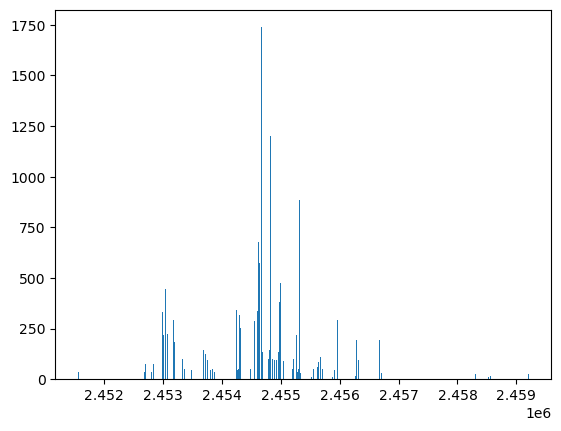

16372
<BarContainer object of 500 artists>


In [17]:
(n, bins, patches) = plt.hist(jds,bins=500)
plt.show()
print(np.sum(np.nonzero(n)))
print(patches)

In [18]:
# fluxes    = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_flux.nda',allow_pickle=True)
# waves     = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_wave.nda',allow_pickle=True)
# erres     = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_error.nda',allow_pickle=True)
# airmasses = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_airmass.nda',allow_pickle=True)
# bcs       = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_bcs.nda',allow_pickle=True)
# jds       = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_jds.nda',allow_pickle=True)
# filenames = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_filenames.nda',allow_pickle=True)
# objnames  = np.load(u'/scratch/mdd423/wobble_jax/data/gj436_objnames.nda',allow_pickle=True)

In [19]:
min_list = np.array([np.min(x) for x in waves])
max_list = np.array([np.max(x) for x in waves])

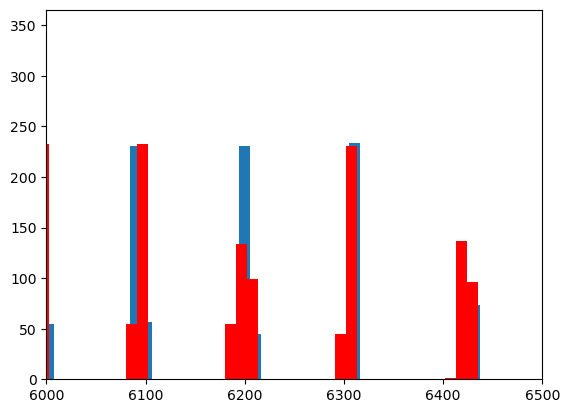

In [20]:
plt.hist(np.exp(min_list),bins=500)
plt.hist(np.exp(max_list),bins=500,color='red')
plt.xlim(6000,6500)
plt.show()

Check for a select order here, and I approximate the end of each to find the values of all lists with wavelengths in that particular order

In [21]:
select_indices = ((min_list > np.log(6050)) * (max_list < np.log(6250))).astype(int)

In [22]:
fluxes_2    =[]
waves_2     =[]
erres_2     =[]
maskes_2 = []

airmasses_2 =[]
bcs_2       =[]
jds_2       = []
filenames_2 = []
objnames_2  = []
for i,t in enumerate(select_indices):
    if t:
        fluxes_2.append(fluxes[i])
        waves_2.append(waves[i])
        erres_2.append(erres[i])
        maskes_2.append((erres[i] < 0.0).astype(bool))
        airmasses_2.append(float(airmasses[i]))
        bcs_2.append(bcs[i])
        jds_2.append(jds[i])
        filenames_2.append(filenames[i])
        objnames_2.append(objnames[i])

airms = np.array([float(x) for x in airmasses_2])

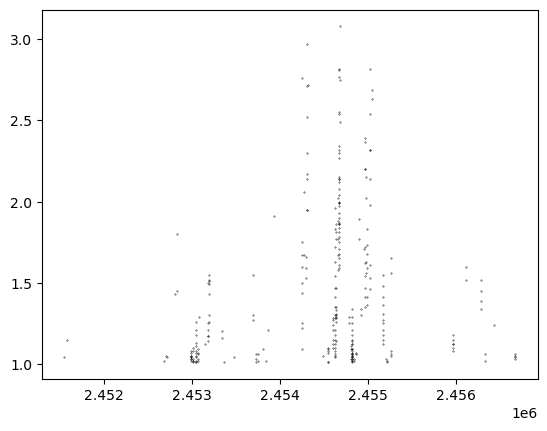

In [23]:
fig,axes  = plt.subplots(1)
axes.plot(jds_2,airmasses_2,'.k',ms=.6)
plt.show()

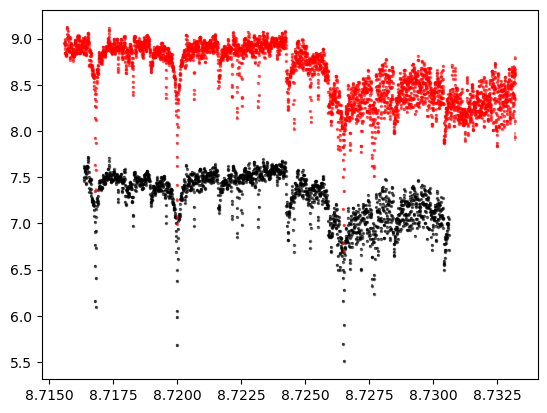

In [24]:
plt_epoch = 4
plt.errorbar(waves_2[plt_epoch][~maskes_2[plt_epoch]],fluxes_2[plt_epoch][~maskes_2[plt_epoch]],\
                             erres_2[plt_epoch][~maskes_2[plt_epoch]],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

plt_epoch = 8
plt.errorbar(waves_2[plt_epoch][~maskes_2[plt_epoch]],fluxes_2[plt_epoch][~maskes_2[plt_epoch]],\
                             erres_2[plt_epoch][~maskes_2[plt_epoch]],fmt='.r',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
plt.show()

In [25]:
import jabble.loss
import jabble.dataset
import jabble.model
import jabble.physics
from dataclasses import dataclass

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


<h2>Now let's use Jabble</h2>
I am going to create a new Data class that has the appropriate xs, ys, yivar values for the loss function.

In [26]:
@dataclass
class Data:
    """Temporary Data Type"""
    xs: list
    ys: list
    yivar: list
    mask: list

    def __getitem__(self,i):
        return Data([self.xs[i]],[self.ys[i]],[self.yivar[i]],[self.mask[i]])

    @property
    def yerr(self):
        return 1/np.sqrt(self.yivar)

class MyChi(jabble.loss.ChiSquare):
    def loss_all(self,p,data,model,*args):
        output = 0.0
        # recall ys are packed st that 0: epoches, 1: pixel
        # if model.save_historyle:
        #     loss_arr = np.zeros(data.ys.shape)
        for ind in range(len(data.ys)):

            output += self(p,data,ind,model,*args).sum()
        # if model.save_history:
        #     model.chi_history.append(loss_arr)
        return output

    def __call__(self, p, data, i, model, *args):
        err = self.coefficient * (((data.ys[i][~data.mask[i]] - model(p,data.xs[i][~data.mask[i]],i,*args))**2) * data.yivar[i][~data.mask[i]])
        return err

In [27]:
import scipy.ndimage

In [28]:
gas_file = scipy.io.readsav('../data/keck_fts_renorm.idl')

In [29]:
type(gas_file['wiod'])

numpy.ndarray

In [30]:
gas_file

{'wiod': array([5000.00177939, 5000.00530293, 5000.00882648, ..., 6319.98828443,
        6319.99391396, 6319.99954349]),
 'siod': array([0.93387033, 0.95355657, 0.96714969, ..., 0.91750472, 0.91229695,
        0.9139045 ]),
 'chunk_len': 250,
 'buffer': 300,
 'note': b'chunk_len = the length of each chunk used for normalization. Buffer= the length of spectrum used to determine the continum',
 'i2_path': b'/Volumes/RAID/rv/I2FTS/keck/',
 'i2_file': b'ftskeck50.bin',
 'tag': b'keckI2_50_norm_all'}

In [31]:
np.min([np.min(x) for x in waves_2])

8.714895357880081

In [32]:
gas_xs = np.log(gas_file['wiod'][(np.log(gas_file['wiod']) > np.min([np.min(x) for x in waves_2]))*(np.log(gas_file['wiod']) < np.max([np.max(x) for x in waves_2]))])

In [33]:
gas_ys = np.log(gas_file['siod'][(np.log(gas_file['wiod']) > np.min([np.min(x) for x in waves_2]))*(np.log(gas_file['wiod']) < np.max([np.max(x) for x in waves_2]))])

In [34]:
gas_ys.shape

(21129,)

In [35]:
resolution = 90_000
gas_cell_spacing = np.mean(gas_xs[1:] - gas_xs[:-1])
dx = jabble.physics.delta_x(resolution)
print((dx/gas_cell_spacing).item())
gas_ys_conv = scipy.ndimage.gaussian_filter(gas_ys,1/(2*np.sqrt(2*np.log(2)))*(dx/gas_cell_spacing).item(),mode='nearest')

12.820804218655304


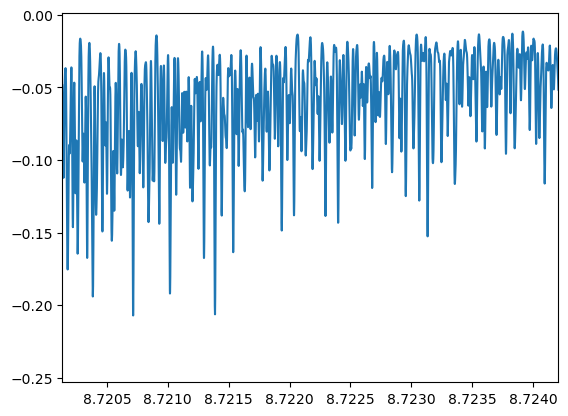

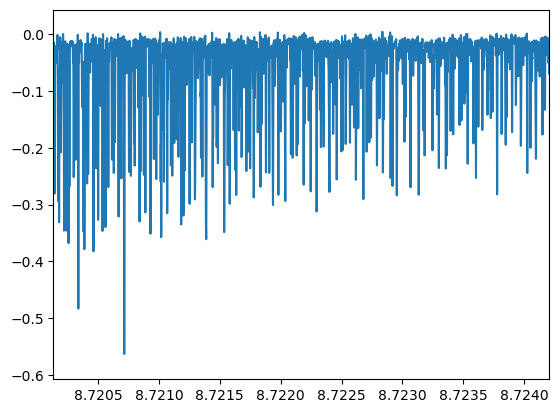

In [36]:
plt.plot(gas_xs,gas_ys_conv)
plt.xlim(np.log(6125),np.log(6150))
plt.show()
plt.plot(gas_xs,gas_ys)
plt.xlim(np.log(6125),np.log(6150))
plt.show()

<h3>Normizing Data as a Model</h3>
Instead of correcting for vignetting, blaze functions, or blackbody effects through a changing the data, we will just add another low data point model that can vary at all epoches. This one works as a Container model that contains a list of models one per each epoch, i.

In [37]:
class NormalizationModel(jabble.model.ContainerModel):
    def get_indices(self,i):
        return np.arange(
                    np.sum(self.parameters_per_model[:i]),
                    np.sum(self.parameters_per_model[: i + 1]),
                    dtype=int,
                )
    
    def call(self, p, x, i, *args):
        indices = self.get_indices(i)
        x = self.models[i](p[indices], x, i, *args)
        return x

In [38]:
yivar_2 = [1/x**2 for x in erres_2]
data = Data(waves_2,fluxes_2,yivar_2,maskes_2)
loss = MyChi()

Make Normalization Model and Fit it!

In [39]:
p_val = 2
gas_model = jabble.model.IrwinHallModel_vmap(np.arange(np.min(gas_xs),np.max(gas_xs),dx/4), p_val)

In [40]:
@dataclass
class GasData:
    """Temporary Data Type"""
    xs: list
    ys: list

    def __getitem__(self,i):
        return Data([self.xs[i]],[self.ys[i]],[self.yivar[i]],[self.mask[i]])

class L2Loss(jabble.loss.LossFunc):
    def __call__(self, p, data, i, model,*args):
        err = self.coefficient * 0.5 * ((data.ys[i] - model(p,data.xs[i],i,*args))**2)
        return err

In [41]:
gas_dataset = GasData(gas_xs[None,:] ,gas_ys_conv[None,:] )

In [42]:
gas_loss = L2Loss()
gas_model.fit()
gas_model.new_lbfgsb(gas_loss,gas_dataset)

{'grad': array([ 2.78442919e-06,  2.35604804e-06, -4.16649407e-06, ...,
        -6.18878106e-08, -1.34060429e-06, -2.00037088e-06]),
 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 12,
 'nit': 11,
 'warnflag': 0}

In [43]:
def make_gas_plot(model,dataset,plt_epoch=0):
    fig, axes = plt.subplots(1,figsize=(4,4),sharex=True,facecolor=(1, 1, 1),dpi=200)
    
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0][1000])
    lmax = np.exp(dataset.xs[0][1500])
    lrange = np.arange(lmin,lmax,5)
    
    model.fix()
    xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
    yplot = model([],xplot,plt_epoch)
    yhat = model([],dataset.xs[plt_epoch],plt_epoch)
    axes.set_xlim(xplot.min(),xplot.max())
    
    axes.plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],'.k',zorder=1,alpha=0.5,ms=3)
    
    axes.plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)

    
    axes.set_xticks([])
    axes.set_xticks(np.log(lrange))
    axes.set_xticklabels(['{:2.0f}'.format(x) for x in lrange])    
    fig.text(0.5, 0.04, '$\lambda$', ha='center')

    plt.savefig(os.path.join(out_dir,'03-gj436-gas-model.png'),dpi=300,bbox_inches='tight')
    plt.show()

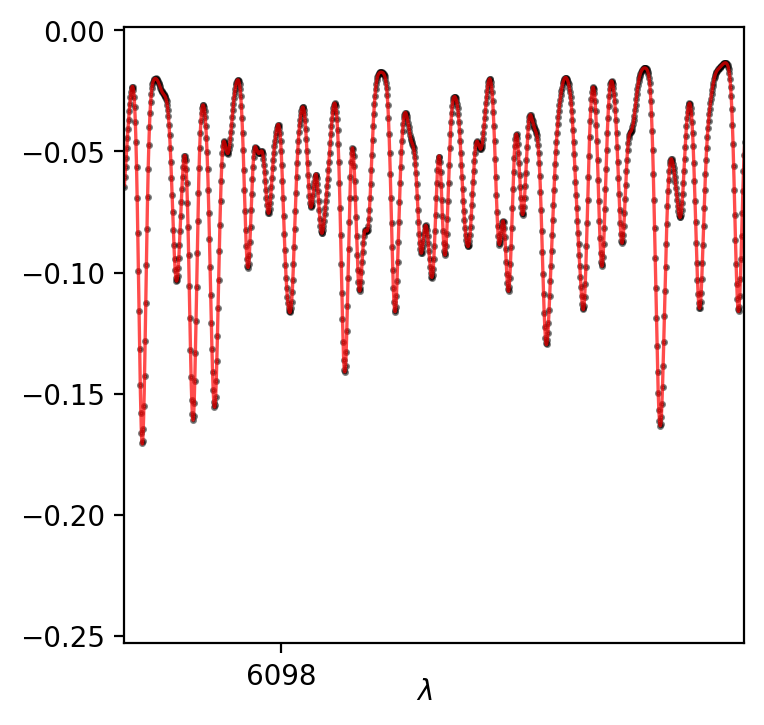

In [44]:
make_gas_plot(gas_model,gas_dataset)

In [45]:
pts_per_wavelength = 1/20
norm_p_val = 7
testdata = Data(waves_2[:3],fluxes_2[:3],yivar_2[:3],maskes_2[:3])
test_norm_model_list = [jabble.model.IrwinHallModel_vmap(np.linspace(np.min(xs),np.max(xs),int((np.exp(np.max(xs)) - np.exp((np.min(xs)))) * pts_per_wavelength)), norm_p_val) for xs in testdata.xs]
test_norm_model = NormalizationModel(test_norm_model_list) + gas_model.composite(jabble.model.StretchingModel(np.ones(len(testdata.xs))))
test_norm_model.fix()
test_norm_model.fit(0)
test_norm_model.fit(1,1)
test_norm_model.display()
test_norm_model.new_lbfgsb(loss, testdata)

-AdditiveModel----------------------------------------------------15
  0-NormalizationModel--------------------------------------------12
  0  0-IrwinHallModel_vmap-----------------------------------------4
  0  1-IrwinHallModel_vmap-----------------------------------------4
  0  2-IrwinHallModel_vmap-----------------------------------------4
  1-CompositeModel-------------------------------------------------3
  1  0-IrwinHallModel_vmap-----------------------------------------0
  1  1-StretchingModel---------------------------------------------3


{'grad': array([-1.86558393e+07,  9.42792343e+06, -3.10665542e+06, -2.59382420e+05,
         2.24023245e+06,  3.10115949e+07, -5.59097766e+05,  2.39111697e+07,
        -2.88034825e+06, -3.20736893e+07, -1.84305717e+06, -4.48728888e+06,
         1.65006674e+04,  7.12844330e+03,  7.06642136e+02]),
 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 103,
 'nit': 30,
 'warnflag': 0}

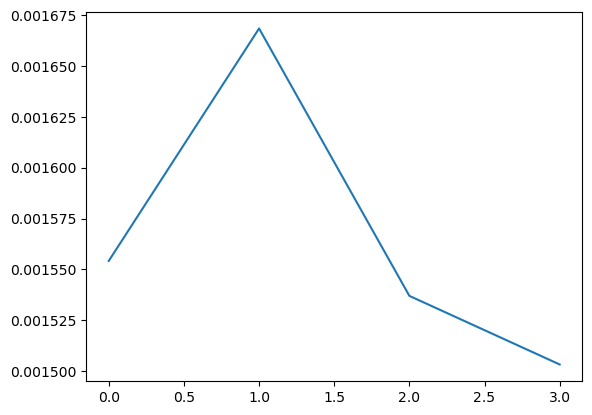

In [46]:
plt.plot(test_norm_model[0][1].p)

In [47]:
def make_better_plot(model,dataset,plt_epoches,gas_xs,gas_ys,lmin,lmax,lrange):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex=True,sharey='row',facecolor=(1, 1, 1),dpi=200)
    
    x_window = np.log(4550) - np.log(4549)
    
    model.fix()
    for ii, plt_epoch in enumerate(plt_epoches):
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
        yplot = model([],xplot,plt_epoch)
        yplot_norm = model[1]([],xplot,plt_epoch)
        yhat = model[0]([],dataset.xs[plt_epoch],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())
        
        
    
        
        axes[0,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
        
        axes[0,ii].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
    
        
        axes[1,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        # axes[1,ii].plot(gas_xs,gas_ys,'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        
        axes[1,ii].plot(xplot,yplot_norm,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[0,ii].set_xticks([])
        axes[1,ii].set_xticks(np.log(lrange))
        axes[1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        # axes[0,ii].set_ylims()
        # axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),'.k',alpha=0.4,ms=1)
        
    fig.text(0.5, 0.04, '$\lambda$', ha='center')

    plt.savefig(os.path.join(out_dir,'03-gj436-norm.png'),dpi=300,bbox_inches='tight')
    plt.show()

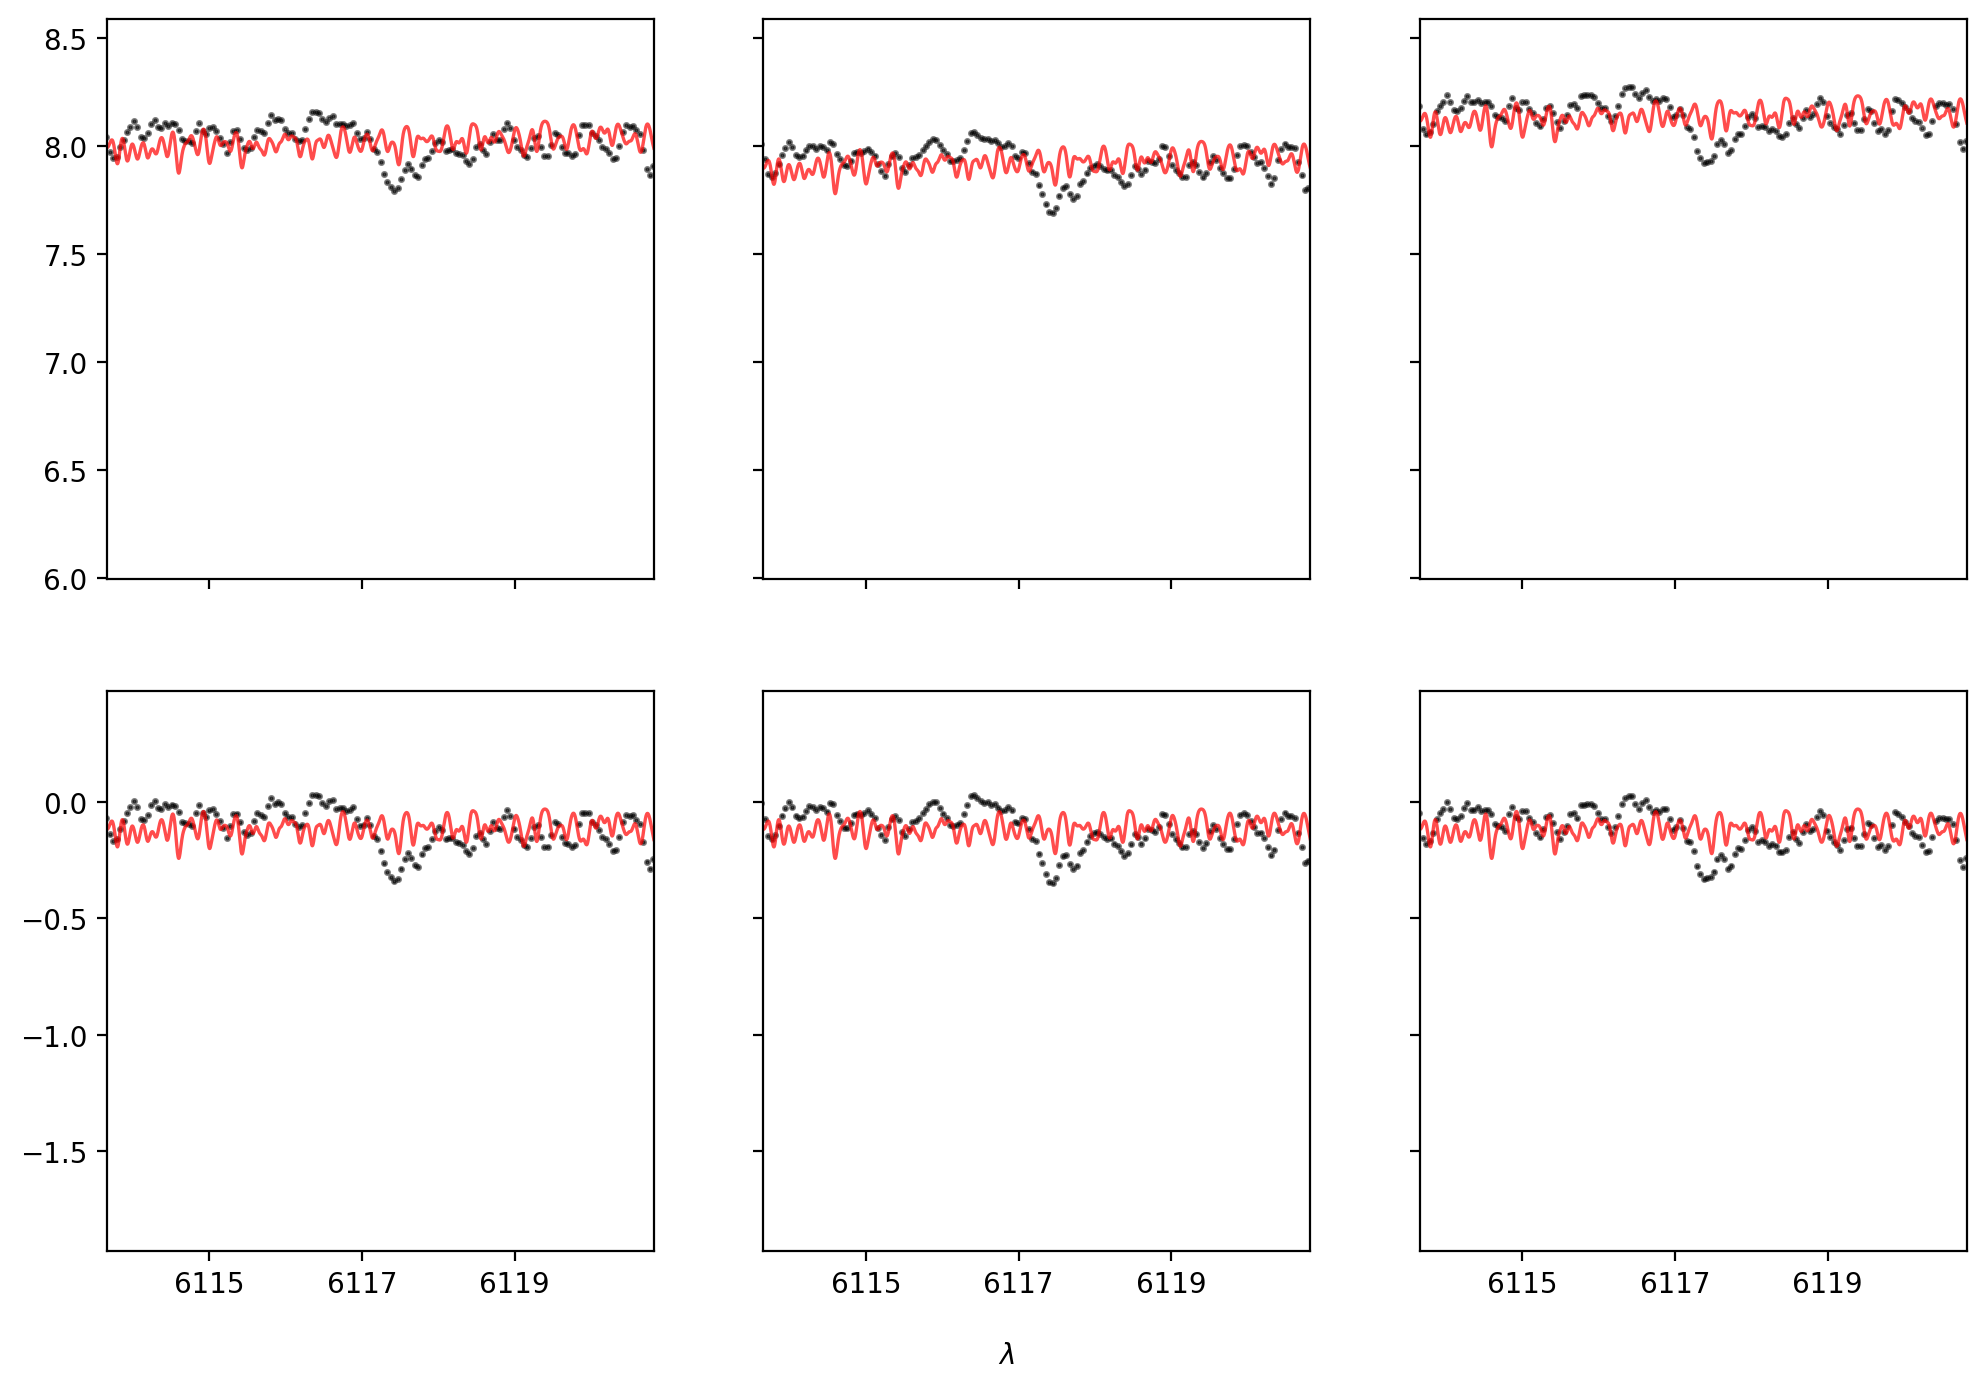

In [48]:
plt_epoches= [0,1,2]
lmin = np.exp(testdata.xs[0][300])
lmax = np.exp(testdata.xs[0][400])
lrange = np.arange(lmin,lmax,2)
make_better_plot(test_norm_model,testdata,plt_epoches,gas_xs,gas_ys_conv,lmin,lmax,lrange)

In [49]:
def get_model(dataset,resolution,p_val,vel_padding,init_shifts,airmass):
    # dx = jabble.physics.delta_x(2 * resolution)
    # x_grid = np.arange(np.min(xs), np.max(xs), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        np.concatenate(dataset.xs), vel_padding, 2 * resolution
    )
    model =   jabble.model.IrwinHallModel_vmap(model_grid, p_val) + \
            jabble.model.ShiftingModel(init_shifts).composite(
                jabble.model.IrwinHallModel_vmap(model_grid, p_val).composite(jabble.model.StretchingModel(airmass)))
    # model =   jabble.model.IrwinHallModel_vmap(model_grid, p_val) + \
    #         jabble.model.ShiftingModel(init_shifts).composite(
    #             jabble.model.IrwinHallModel_vmap(model_grid, p_val).composite(jabble.model.StretchingModel(airmass)) + \
    #             gas_model.composite(jabble.model.StretchingModel(epoches=len(airmass)))
    # )

    return model

In [50]:

xs = np.concatenate(data.xs)

In [51]:
def get_norm_model(pts_per_wavelength,norm_p_val,p_val,data,resolution,vel_padding,init_shifts,airmass):
    xs = np.concatenate(data.xs)
    model_list = [jabble.model.IrwinHallModel_vmap(\
        np.linspace(np.min(xs),np.max(xs),\
                    int((np.exp(np.max(xs)) - np.exp((np.min(xs)))) * pts_per_wavelength)\
                   ), norm_p_val) for xs in data.xs]
    norm_model = NormalizationModel(model_list) + get_model(data,resolution,p_val,vel_padding,init_shifts,airmass)
    return norm_model

In [52]:
norm_p_val = 7
p_val = 3

init_shifts = jabble.physics.shifts(np.array(bcs_2))
vel_padding = 60_000

norm_pts = [1/40]
norm_models = [get_norm_model(pts_per_wavelength,norm_p_val,p_val,data,resolution,vel_padding,init_shifts,airmasses_2) for pts_per_wavelength in norm_pts]

In [53]:
norm_models[0].display()

-AdditiveModel------------------------------------0
  0-NormalizationModel---------------------------------------------0
  0  0-IrwinHallModel_vmap-----------------------------------------0
  0  1-IrwinHallModel_vmap-----------------------------------------0
  0  2-IrwinHallModel_vmap-----------------------------------------0
  0  3-IrwinHallModel_vmap-----------------------------------------0
  0  4-IrwinHallModel_vmap-----------------------------------------0
  0  5-IrwinHallModel_vmap-----------------------------------------0
  0  6-IrwinHallModel_vmap-----------------------------------------0
  0  7-IrwinHallModel_vmap-----------------------------------------0
  0  8-IrwinHallModel_vmap-----------------------------------------0
  0  9-IrwinHallModel_vmap-----------------------------------------0
  0  10-IrwinHallModel_vmap----------------------------------------0
  0  11-IrwinHallModel_vmap----------------------------------------0
  0  12-IrwinHallModel_vmap------------------------

In [54]:
norm_models

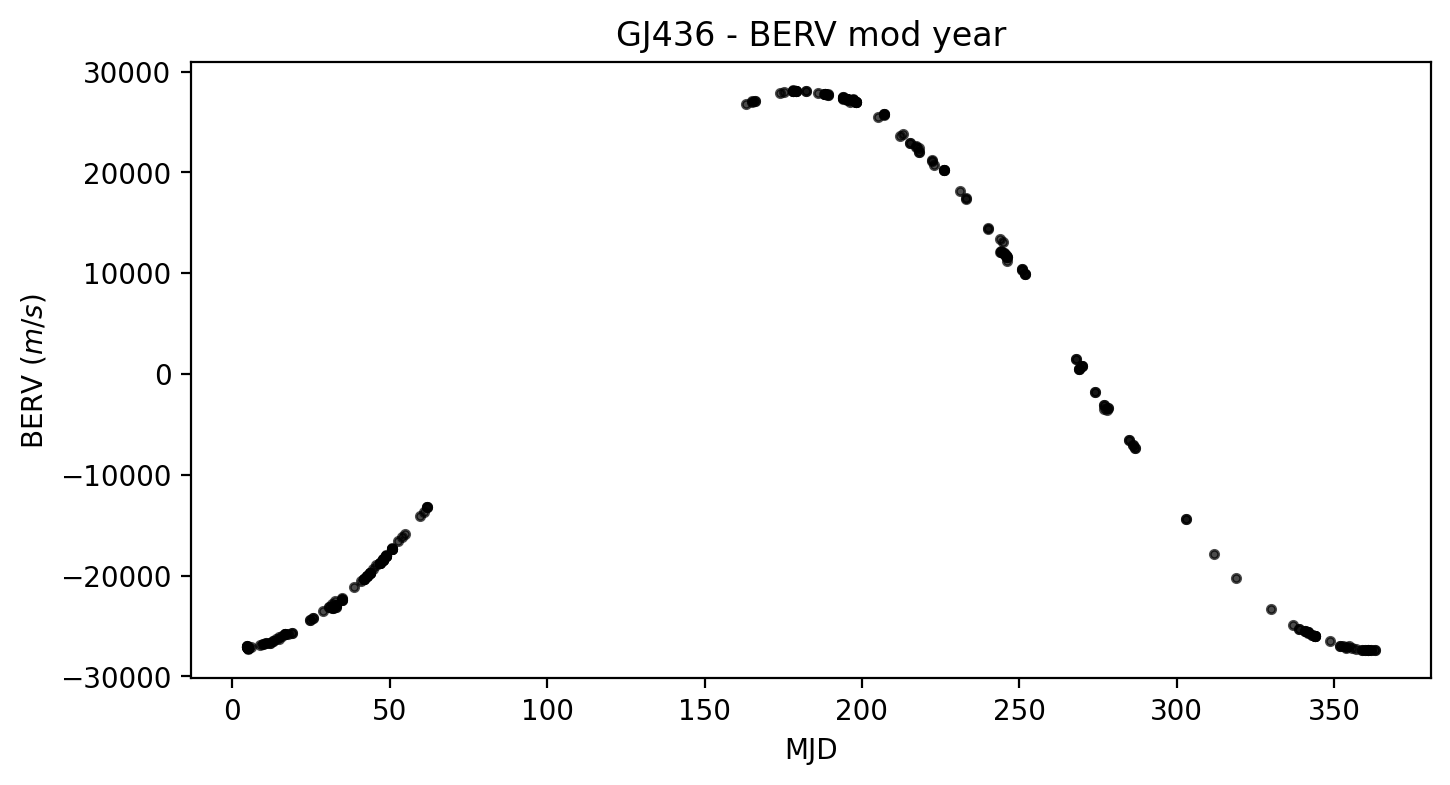

In [55]:
fig, axes = plt.subplots(1,figsize=(8,4),facecolor=(1, 1, 1),dpi=200)
axes.plot([x%365.0 for x in jds_2],bcs_2,'.k',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
axes.set_ylabel('BERV ($m/s$)')
axes.set_xlabel('MJD')
axes.set_title('GJ436 - BERV mod year')
plt.savefig(os.path.join(out_dir,'03-gj436-berv-year.png'.format(np.min(lrange),np.max(lrange))))
plt.show()

In [56]:
def fit_cycle(model,loss,data):

    # Fit Normalization
    model.fix()
    model.fit(0)
    res = model.new_lbfgsb(loss, data)
    print(res)

    # Fit Templates
    model.fix()
    model.fit(1,0)
    model.fit(1,1,1,0)
    # model.fit(1,1,1,1,1)
    res = model.new_lbfgsb(loss, data)
    print(res)

    # Fit RVs
    model.fix()
    model.fit(1,1,0)
    res = model.new_lbfgsb(loss, data)
    print(res)

    # All together now
    model.fix()
    model.fit(0)
    model.fit(1,0)
    model.fit(1,1,0)
    model.fit(1,1,1,0)
    # model.fit(1,1,1,1,1)
    res = model.new_lbfgsb(loss, data)
    print(res)

    return model

Now we are going to fit a model to just the first the normalization modeled epoch.

In [57]:
for norm_model in norm_models:
    fit_cycle(norm_model,loss,data)

{'grad': array([ 2.63710978e+06, -1.80128273e+06,  3.49278491e+05, -2.37919319e+05,
        6.51345907e+06, -4.48222471e+06, -2.29731851e+06,  1.57378494e+06,
       -6.11782155e+06,  2.20084121e+06, -7.59478586e+06,  4.53272426e+06,
        5.55302264e+06, -3.78694200e+06, -2.42601567e+06,  1.70918866e+06,
        5.55923632e+06, -3.92237286e+06, -6.21520210e+04,  4.26713889e+04,
       -3.02068900e+05,  2.08335405e+05,  3.38259819e+05, -2.38594380e+05,
       -1.18929705e+06, -1.24430858e+07,  5.20431092e+04, -3.58119450e+04,
       -1.02307803e+07,  6.97074445e+06, -9.55664292e+06,  6.37812740e+06,
        1.59746842e+05, -1.11676359e+05,  6.37955611e+05, -4.40627936e+05,
        3.13172415e+05, -2.15927169e+05, -1.39473694e+06,  9.67639921e+05,
        1.13973254e+07,  3.12099730e+06, -7.64441775e+06,  5.04806785e+06,
        7.56736400e+06, -5.25110936e+06,  4.03573997e+05, -2.77525175e+05,
        2.98432533e+06, -2.04325829e+06,  1.64263019e+05, -1.12221471e+05,
        5.353345

In [58]:
def make_norm_plot(model,dataset,plt_epoches,gas_xs,gas_ys,lmin,lmax,lrange):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex=True,sharey='row',facecolor=(1, 1, 1),dpi=200)
    
    x_window = np.log(4550) - np.log(4549)

    
    model.fix()
    for ii, plt_epoch in enumerate(plt_epoches):
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
        yplot = model[0]([],xplot,plt_epoch)
        yplot_norm_tell = model[1][1]([],xplot,plt_epoch)
        yplot_norm_stel = model[1][0]([],xplot,plt_epoch)
        yhat = model[0]([],dataset.xs[plt_epoch],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())
        
        
    
        
        axes[0,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
        
        axes[0,ii].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
     
        axes[1,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        # axes[1,ii].plot(gas_xs,gas_ys,'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        
        axes[1,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[1,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[0,ii].set_xticks([])
        axes[1,ii].set_xticks(np.log(lrange))
        axes[1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        # axes[0,ii].set_ylims()
        # axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),'.k',alpha=0.4,ms=1)
        
    fig.text(0.5, 0.04, '$\lambda$', ha='center')

    plt.savefig(os.path.join(out_dir,'03-gj436-norm-stel-tell-{}_{}.png'.format(np.min(lrange),np.max(lrange))),dpi=300,bbox_inches='tight')
    plt.show()

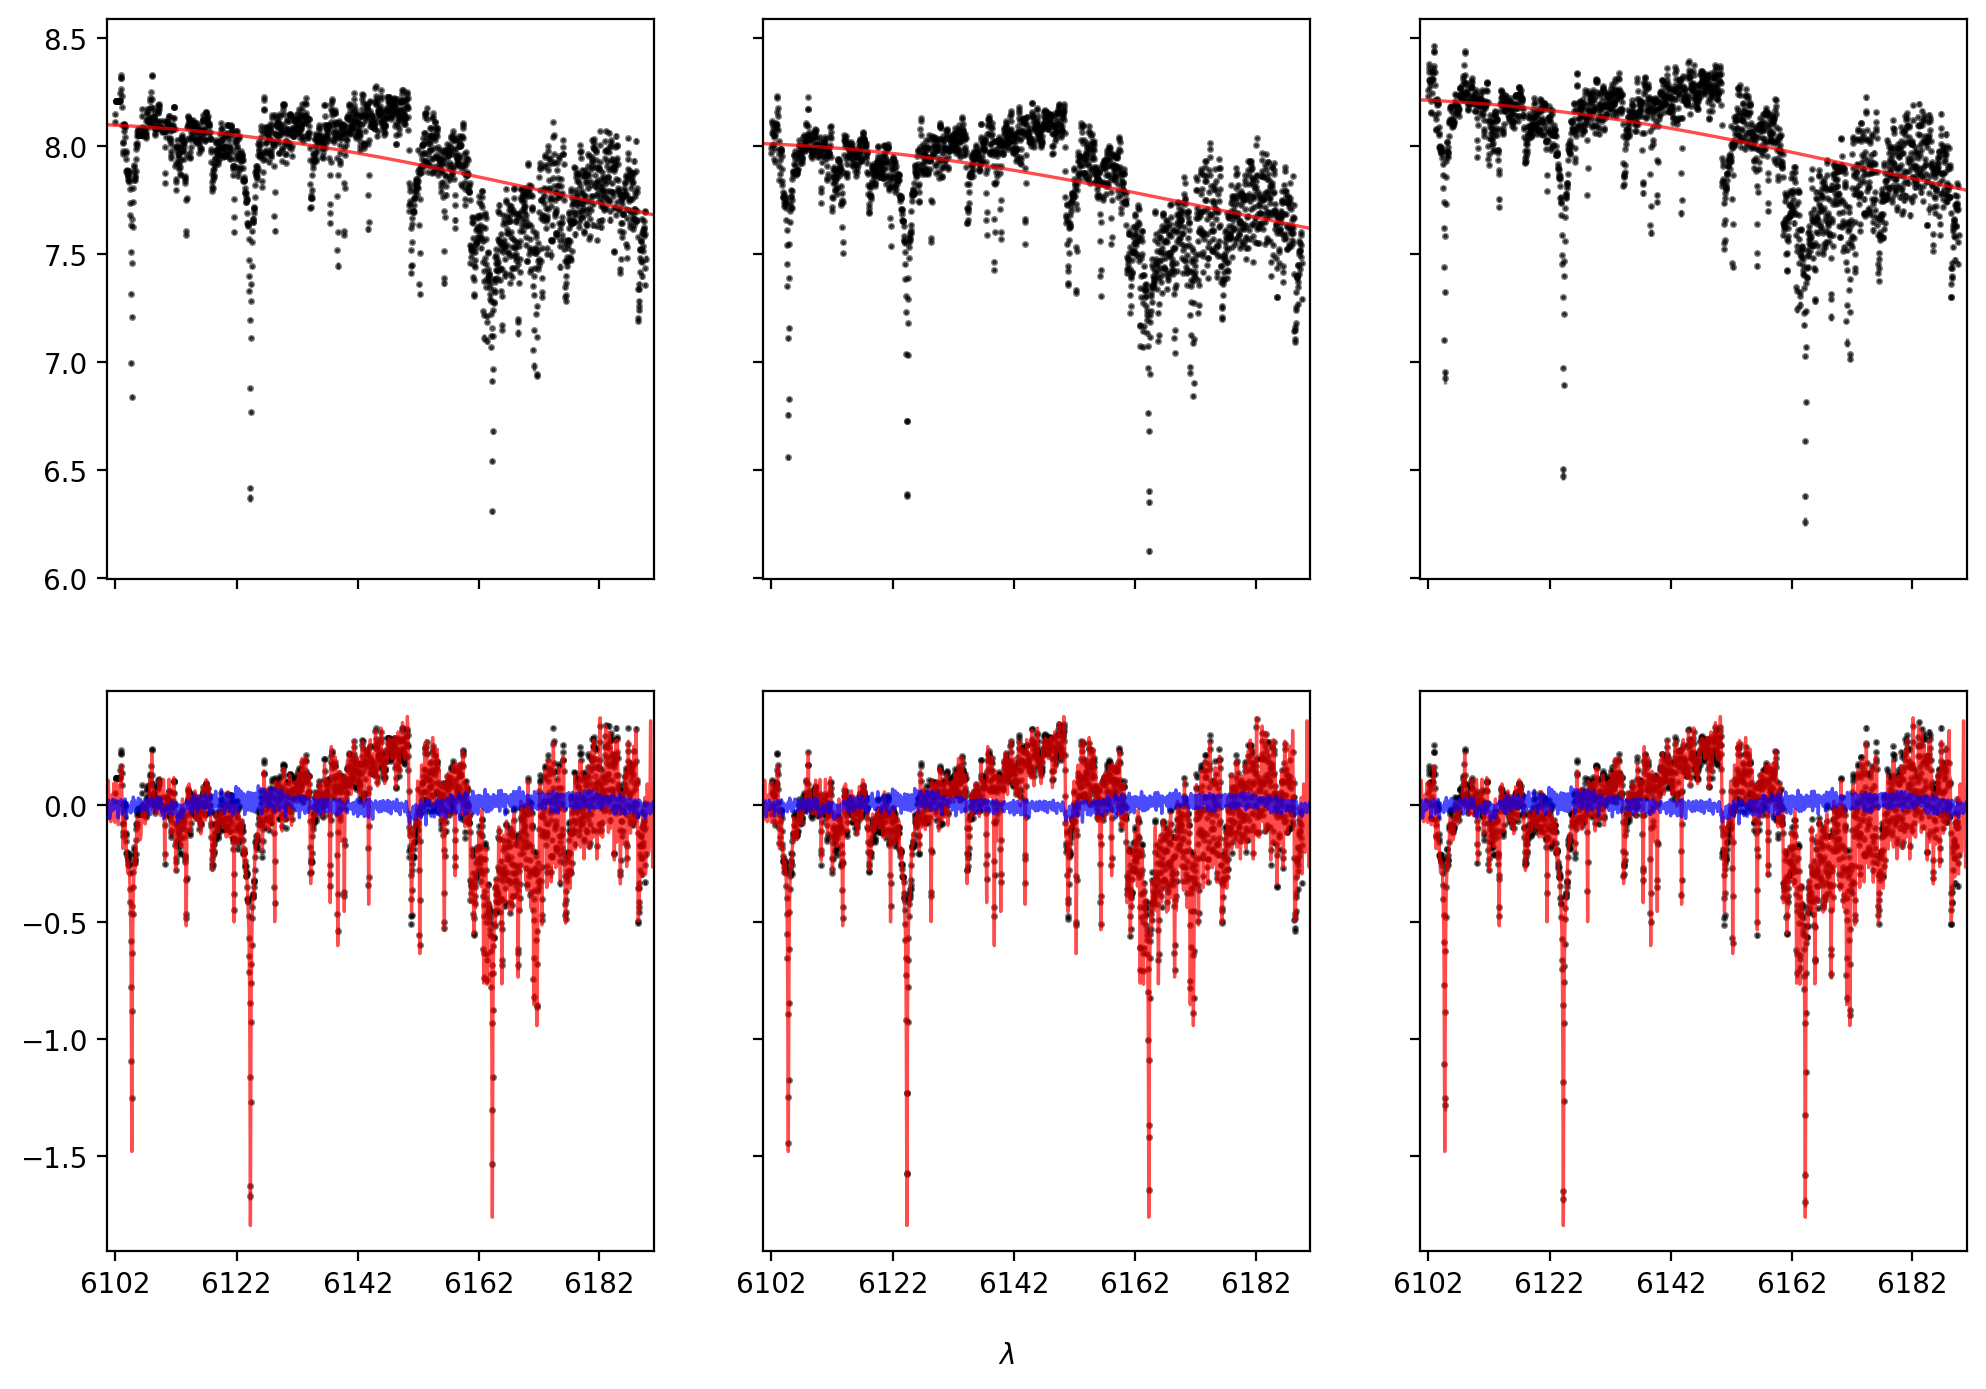

In [74]:
plt_epoches= [0,1,2]
lmin = np.exp(testdata.xs[0][0])
lmax = np.exp(testdata.xs[0][-1])
lrange = np.arange(lmin,lmax,20)
make_norm_plot(norm_model,data,plt_epoches,gas_xs,gas_ys_conv,lmin,lmax,lrange)

In [60]:
def make_gas_plot(model,dataset,plt_epoches,gas_xs,gas_ys,lmin,lmax,lrange):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex='row',sharey='row',facecolor=(1, 1, 1),dpi=200)
    
    x_window = np.log(4550) - np.log(4549)
    
    model.fix()
    for ii, plt_epoch in enumerate(plt_epoches):
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
        yplot = model[0]([],xplot,plt_epoch)
        yplot_norm_tell = model[1][1]([],xplot,plt_epoch)
        yplot_norm_stel = model[1][0]([],xplot,plt_epoch)
        yhat = model[0]([],dataset.xs[plt_epoch],plt_epoch)

        ccf_span = np.linspace(-4*x_window,4*x_window,100)
        ccf_arr = ccf(model[1][0],gas_xs,gas_ys,ccf_span,plt_epoch)
        axes[1,ii].plot(ccf_span,ccf_arr,'.k')
        
        axes[0,ii].set_xlim(xplot.min(),xplot.max())
        yplot_norm_tell_gas = model[1][1]([],gas_xs,plt_epoch)
        # axes[ii].plot(model[1][1][0]([],gas_xs,plt_epoch),gas_ys - yplot_norm_tell_gas,'.k',linewidth=1.2,zorder=1,alpha=0.7,ms=3)
        axes[0,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.1,ms=3)

        # axes[1,ii].plot(gas_xs,gas_ys,'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)

        axes[0,ii].plot(model[1][1][0]([],gas_xs,plt_epoch),gas_ys,'-g',zorder=2,alpha=0.7,ms=0.6)
        axes[0,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=2,alpha=0.1,ms=6)
        axes[0,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[0,ii].set_xticks([])
        axes[0,ii].set_xticks(np.log(lrange))
        axes[0,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[0,ii].set_ylim(-0.5,0.2)
        # axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),'.k',alpha=0.4,ms=1)
        
    fig.text(0.5, 0.04, '$\lambda$', ha='center')

    plt.savefig(os.path.join(out_dir,'03-gj436-norm-gas-{}_{}.png'.format(np.min(lrange),np.max(lrange))),dpi=300,bbox_inches='tight')
    plt.show()

In [64]:
resolution = 80_000
gas_cell_spacing = np.mean(gas_xs[1:] - gas_xs[:-1])
dx = jabble.physics.delta_x(resolution)
print((dx/gas_cell_spacing).item())
gas_ys_conv = scipy.ndimage.gaussian_filter(gas_ys,1/(2*np.sqrt(2*np.log(2)))*(dx/gas_cell_spacing).item(),mode='nearest')

14.423394729707836


In [65]:
def ccf(model,xs,ys,x_span,plt_epoch):
    ccf_arr = np.zeros(len(x_span))
    ys_temp = ys - np.mean(ys)
    for i,diff_x in enumerate(x_span):
        shift_temp = model([],xs+diff_x,plt_epoch)
        ccf_arr[i] = np.dot(ys_temp, shift_temp - shift_temp.mean())
    return ccf_arr   

In [95]:
def rv_plot(model,dataset,velocities,times,period):
    fig, ax = plt.subplots(
        figsize=(8, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True,
    )
     
    # velocities = jabble.physics.velocities(shifts) * u.m/u.s
    epoches = len(dataset.xs)
    epoch_range = np.arange(0, epoches, dtype=int)
    fischer_information = np.zeros(epoches)
    for e_num in range(epoches):
        model.fix()
        model.fit(1,1,0)
        temp = jax.jacfwd(model, argnums=0)(model.get_parameters(),dataset.xs[e_num][:],e_num)
        # print(temp.shape)
        fischer_information[e_num] = jnp.dot(
            temp[:, e_num] ** 2, dataset.yivar[e_num][ :]
        )
    dvddx = jnp.array(
        [jax.grad(jabble.physics.velocities)(x) for x in model[1][1][0].p]
    )
    verr = np.sqrt(1 / fischer_information) * dvddx
    estimate_vel = jabble.physics.velocities(model[1][1][0].p)
    tv = velocities - np.mean(velocities)
    ev = estimate_vel - estimate_vel.mean()
    ax.plot(
        times % period,
        tv - tv,
        "-r",
        linewidth=1.2,
        zorder=1,
        alpha=0.3,
        ms=6,
    )

    ax.errorbar(times % period,tv - ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

    # ax[i].set_title('{}'.format(filenames[i], model_set[i][1][0].p_val))
    # ax.set_xlim(-0.5, epoches - 0.5)
    fig.text(0.04, 0.5, "$v_{truth} - v_{est}$ [$m/s$]", va="center", rotation="vertical")
    fig.text(0.5, 0.04, "epochs", ha="center")
    plt.savefig(os.path.join(out_dir, "02-dv-barn-51peg.png"))
    plt.show()

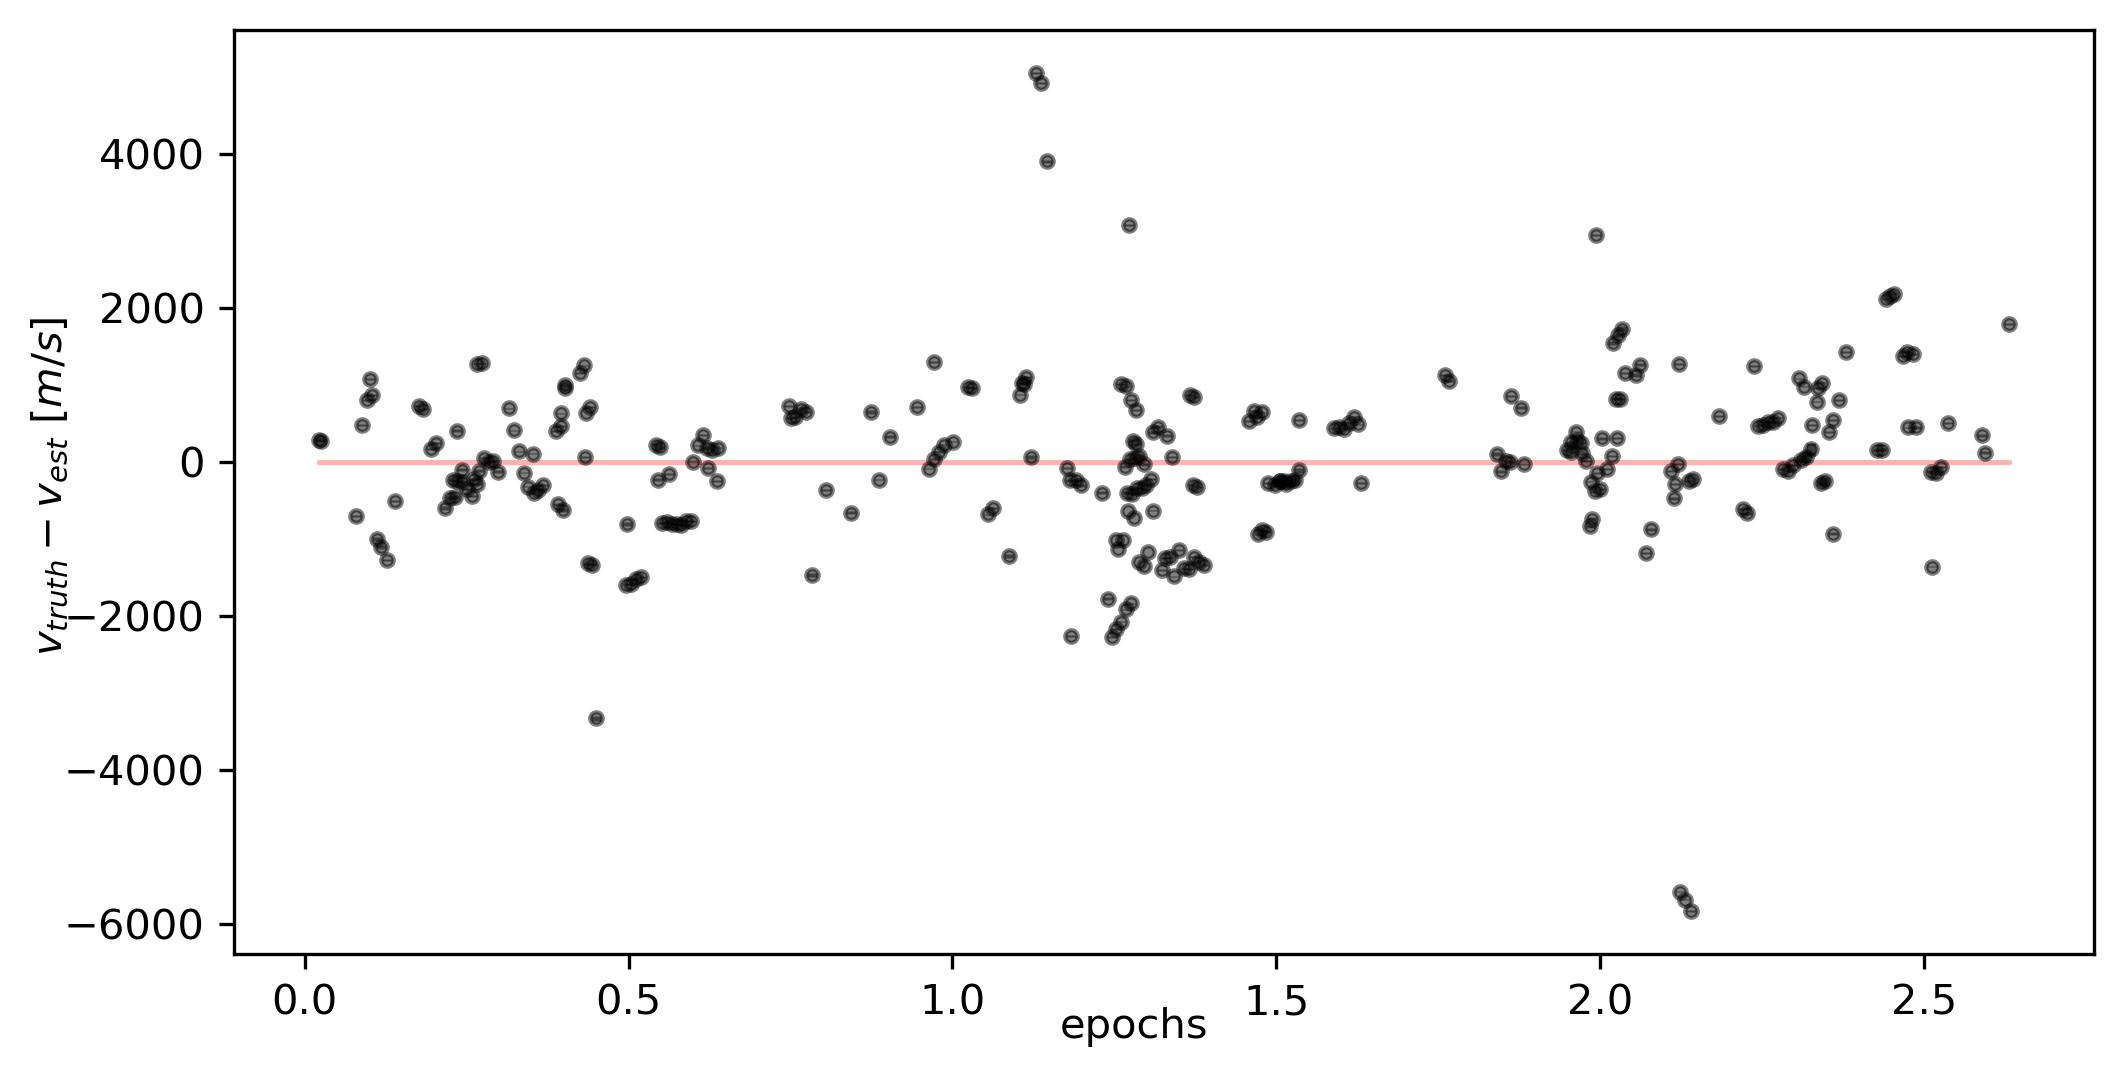

In [97]:
period = 2.64390
rv_plot(norm_models[0],data,bcs_2,np.array(jds_2),period)

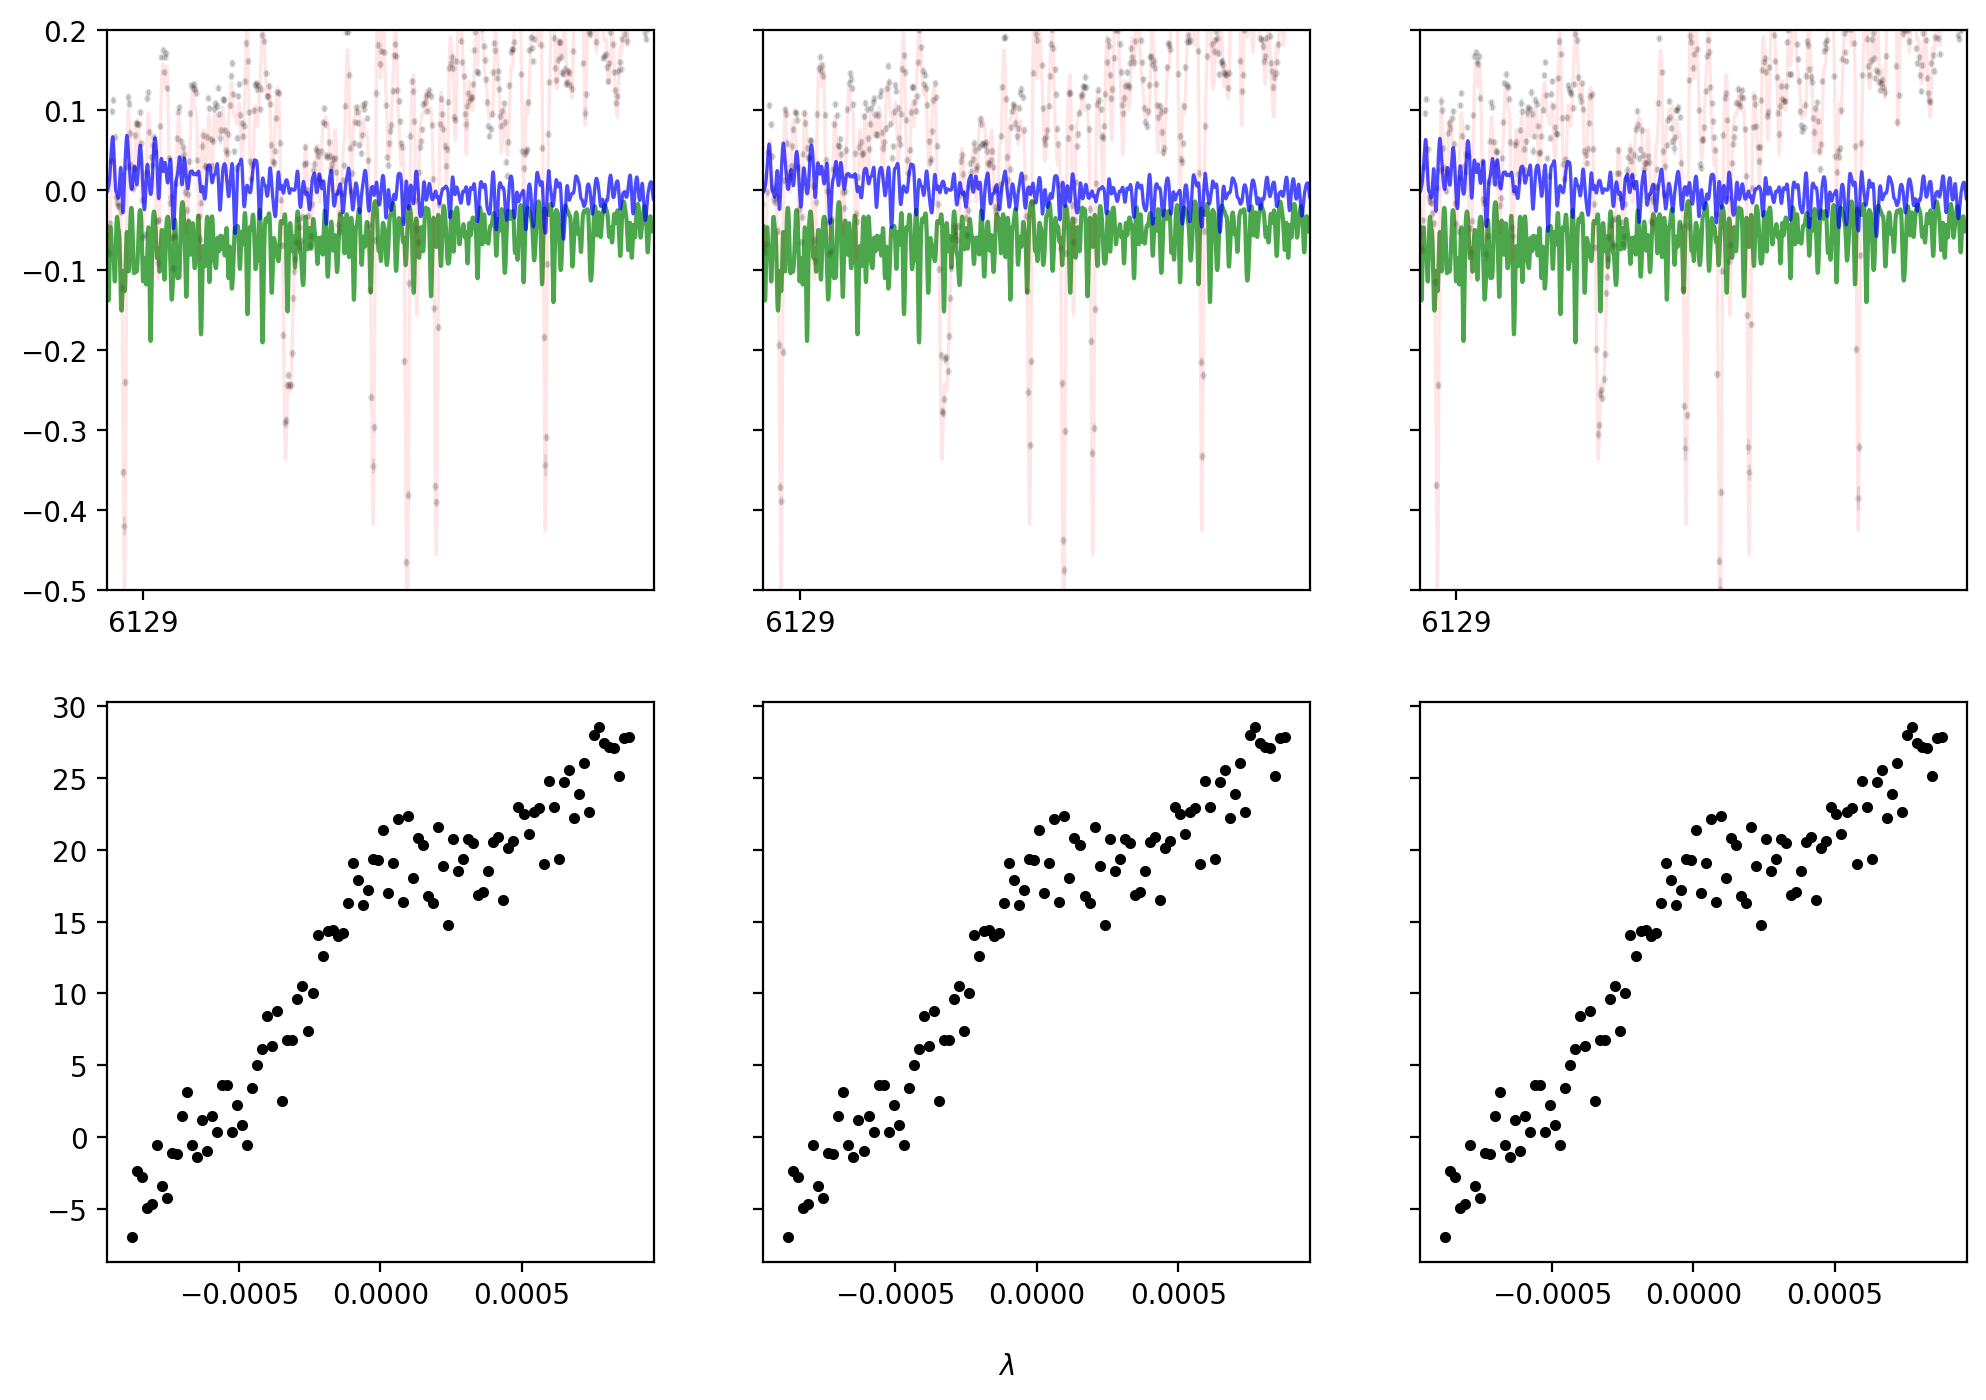

In [66]:
plt_epoches= [0,1,2]
lmin = np.exp(testdata.xs[0][600])
lmax = np.exp(testdata.xs[0][1000])
lrange = np.arange(lmin,lmax,20)
make_gas_plot(norm_model,data,plt_epoches,gas_xs,gas_ys_conv,lmin,lmax,lrange)

Here we create the normalized first model, note that by only fitting the lower frequencies first we can freeze them out. Then fit for redshift with respect the high frequency absorption lines.

In [ ]:
# vel_padding = 60_000
# resolution  = 90_000
# model_grid       = jabble.model.create_x_grid(data.xs[0], vel_padding, resolution)
# stellar_template = jabble.model.IrwinHallModel_vmap(model_grid, p_val)
# init_model = stellar_template + norm_model[0]

In [ ]:
# init_model.fix()
# init_model.fit(0)
# init_model.new_lbfgsb(loss, data[0])

In [ ]:
def make_init_plot(model,dataset,plt_epoch):
    fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True,facecolor=(1, 1, 1),dpi=200)
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0][500])
    lmax = np.exp(dataset.xs[0][1500])
    lrange = np.arange(lmin,lmax,10)

    model.fix()
    xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
    yplot = model([],xplot,plt_epoch)
    yhat = model([],dataset.xs[plt_epoch],plt_epoch)
    axes[0].set_xlim(xplot.min(),xplot.max())
    
    axes[0].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
                             dataset.yerr[plt_epoch][:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
    
    axes[0].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)

    ypnorm = model[1]([],xplot,plt_epoch)
    yhnorm = model[1]([],dataset.xs[plt_epoch],plt_epoch)
    axes[1].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhnorm,\
                             dataset.yerr[plt_epoch][:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
    
    axes[1].plot(xplot,yplot - ypnorm,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
    
    axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[0].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    
    plt.savefig(os.path.join(out_dir,'03-gj436-init.png'),dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
make_init_plot(init_model,data[0],0)

In [ ]:
start_shifts = jabble.physics.shifts(np.array(bcs_2))

In [ ]:
start_shifts = start_shifts - start_shifts[0]
model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(start_shifts),
            stellar_template
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
            jabble.model.StretchingModel(airms),
        ]
    ) + norm_model

In [ ]:
model.fix()
dx = jabble.physics.delta_x(resolution)
shift_search = np.arange(jabble.physics.shifts(-60000),jabble.physics.shifts(60000), 2*dx)
print(shift_search.shape)

In [ ]:
model[0][0].parabola_fit(shift_search, loss, model, data)

In [ ]:
def train_cycle(model, dataset, loss):
    n_cycles = 1

    options1 = {"pgtol": 0.0}
    options2 = {"pgtol": 0.0}
    for iii in range(n_cycles):

        model.fix()
        model.fit(0, 1)
        res1 = model.new_lbfgsb(loss, dataset, options=options1)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        model.fit(1, 0)
        res1 = model.new_lbfgsb(loss, dataset, options=options2)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        model.fit(0, 0)
        res1 = model.new_lbfgsb(loss, dataset, options=options1)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        shift_search = jabble.physics.shifts(np.linspace(-10, 10, 100))
        model[0][0].parabola_fit(shift_search, loss, model, dataset)

        model.fix()
        model.fit(0, 0)
        model.fit(0, 1)
        model.fit(1, 0)
        res1 = model.new_lbfgsb(loss, dataset, options=options2)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        model.fit(1, 1)
        res1 = model.new_lbfgsb(loss, dataset, options=options2)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

    return model